In [1]:
#Data Pipeline : Extract
import pandas as pd
df1 = pd.read_csv('updated_issues.csv')
print(df1.shape)
print(df1.columns)

(2375, 11)
Index(['Unnamed: 0', 'Issue Id', 'Description', 'Assignee_Id',
       'Assignee_email', 'Reporter_id', 'Reporter_email', 'Creation Date',
       'Close Date', 'Estimated Time', 'Actual Time'],
      dtype='object')


Duplicate rows = 0
################
Missing data
Issue Id           0
Description        0
Assignee_Id        0
Assignee_email     0
Reporter_id        0
Reporter_email     0
Creation Date      0
Close Date        64
Estimated Time     0
Actual Time        0
dtype: int64


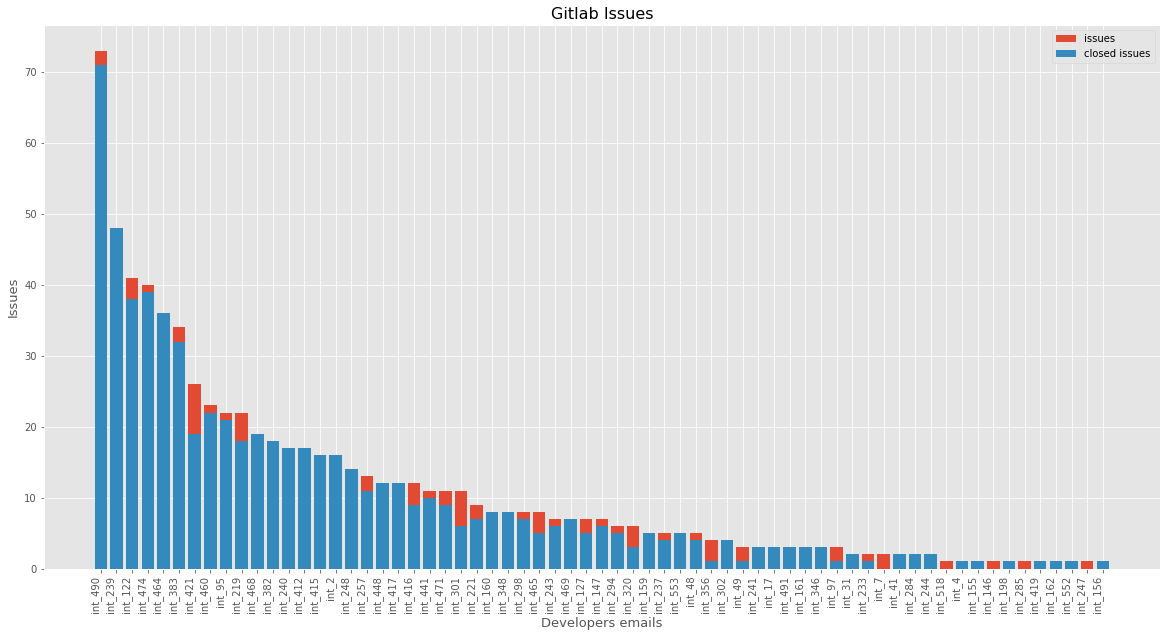

In [3]:
#Data Pipeline : Transform
import matplotlib.pyplot as plt

#remove index , use default pandas index
df1 = df1.drop('Unnamed: 0', axis = 1, errors='ignore')
print(f'Duplicate rows = {df1.duplicated().sum()}')
#Handling Missing cells
print("################")
print("Missing data")
print(df1.isnull().sum())
df1 = df1.dropna(subset = ['Assignee_Id', 'Assignee_email' ,'Reporter_email']).reset_index(drop=True)
aggregateData = df1.groupby(['Assignee_email']).agg({'Issue Id': 'count'})
employees = pd.DataFrame({'total_tasks': aggregateData['Issue Id']}).reset_index()

employees.to_csv('result/employees.csv')
df1.to_csv('result/issues.csv')

#plot-employees progress
closed_tasks_email = df1[df1['Close Date'].notnull()]['Assignee_email'].value_counts()
issues_by_email = df1['Assignee_email'].value_counts()
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.title("Gitlab Issues", fontsize='16')
index = issues_by_email.keys()
plt.bar(index, issues_by_email ,label = "issues")
index2 = closed_tasks_email.keys()
plt.bar(index2, closed_tasks_email, label="closed issues")
plt.xlabel("Developers emails",fontsize='13')
plt.ylabel("Issues",fontsize='13')
plt.setp(plt.xticks()[1], rotation=90, ha='right') 
plt.legend()
plt.show()

In [5]:
#Data Pipeline : load 
from neo4j import GraphDatabase

class Neo4jConnection:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password),encrypted=False)

    def close(self):
        self.driver.close()

    def query(self, query, parameters=None, db=None):
        assert self.driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.driver.session(database=db) if db is not None else self.driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


if __name__ == "__main__":
    
    NEO4J_HOST = "neo4j"
    NEO4J_PORT = 7687
    NEO4J_USERNAME = "neo4j"
    NEO4J_PASSWORD = "test"

    NEO4J_URI = "neo4j://{NEO4J_HOST}:{NEO4J_PORT}".format(NEO4J_HOST=NEO4J_HOST,NEO4J_PORT=NEO4J_PORT)
    conn = Neo4jConnection(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD)

In [6]:
#temp solution : docker cp /home/waedas/Downloads/df1.csv a2c1e3fd503f:/var/lib/neo4j/import
conn.query('CREATE CONSTRAINT employeesConstraint IF NOT EXISTS ON (E:Employee) ASSERT E.Assignee_email IS UNIQUE')

#employee node
conn.query('LOAD CSV WITH HEADERS FROM "file:///employees.csv" AS row \
           CREATE (E:Employee) \
           SET E.Assignee_email = row.Assignee_email \
           SET E.total_tasks = row.total_tasks \
           RETURN count(*) as total')

[<Record total=65>]

In [7]:
conn.query('CREATE CONSTRAINT taskConstraint IF NOT EXISTS ON (T:Task) ASSERT T.`Issue Id` IS UNIQUE')
conn.query('LOAD CSV WITH HEADERS FROM "file:///issues.csv" AS row \
           CREATE (T:Task) \
           SET T.Issue_Id = row.`Issue Id` \
           SET T.Assignee_email = row.Assignee_email \
           SET T.Reporter_email = row.Reporter_email \
           SET T.Creation_Date = row.`Creation Date` \
           SET T.Close_Date  = coalesce(row.`Close Date`, "open")  \
           SET T.Estimated_Time = toInteger(row.`Estimated Time`) \
           SET T.Actual_Time = toInteger(row.`Actual Time`) \
           RETURN count(*) as total \
           ')


[<Record total=717>]

In [8]:
#Relationships 
conn.query('MATCH (E:Employee), (T:Task) WHERE E.Assignee_email = T.Reporter_email \
            CREATE (E)-[r: create_task ]->(T)')

[]

In [9]:
conn.query('MATCH (T:Task), (E:Employee) WHERE T.Assignee_email = E.Assignee_email \
            CREATE (T)-[r: assignee_to ]->(E)')

[]

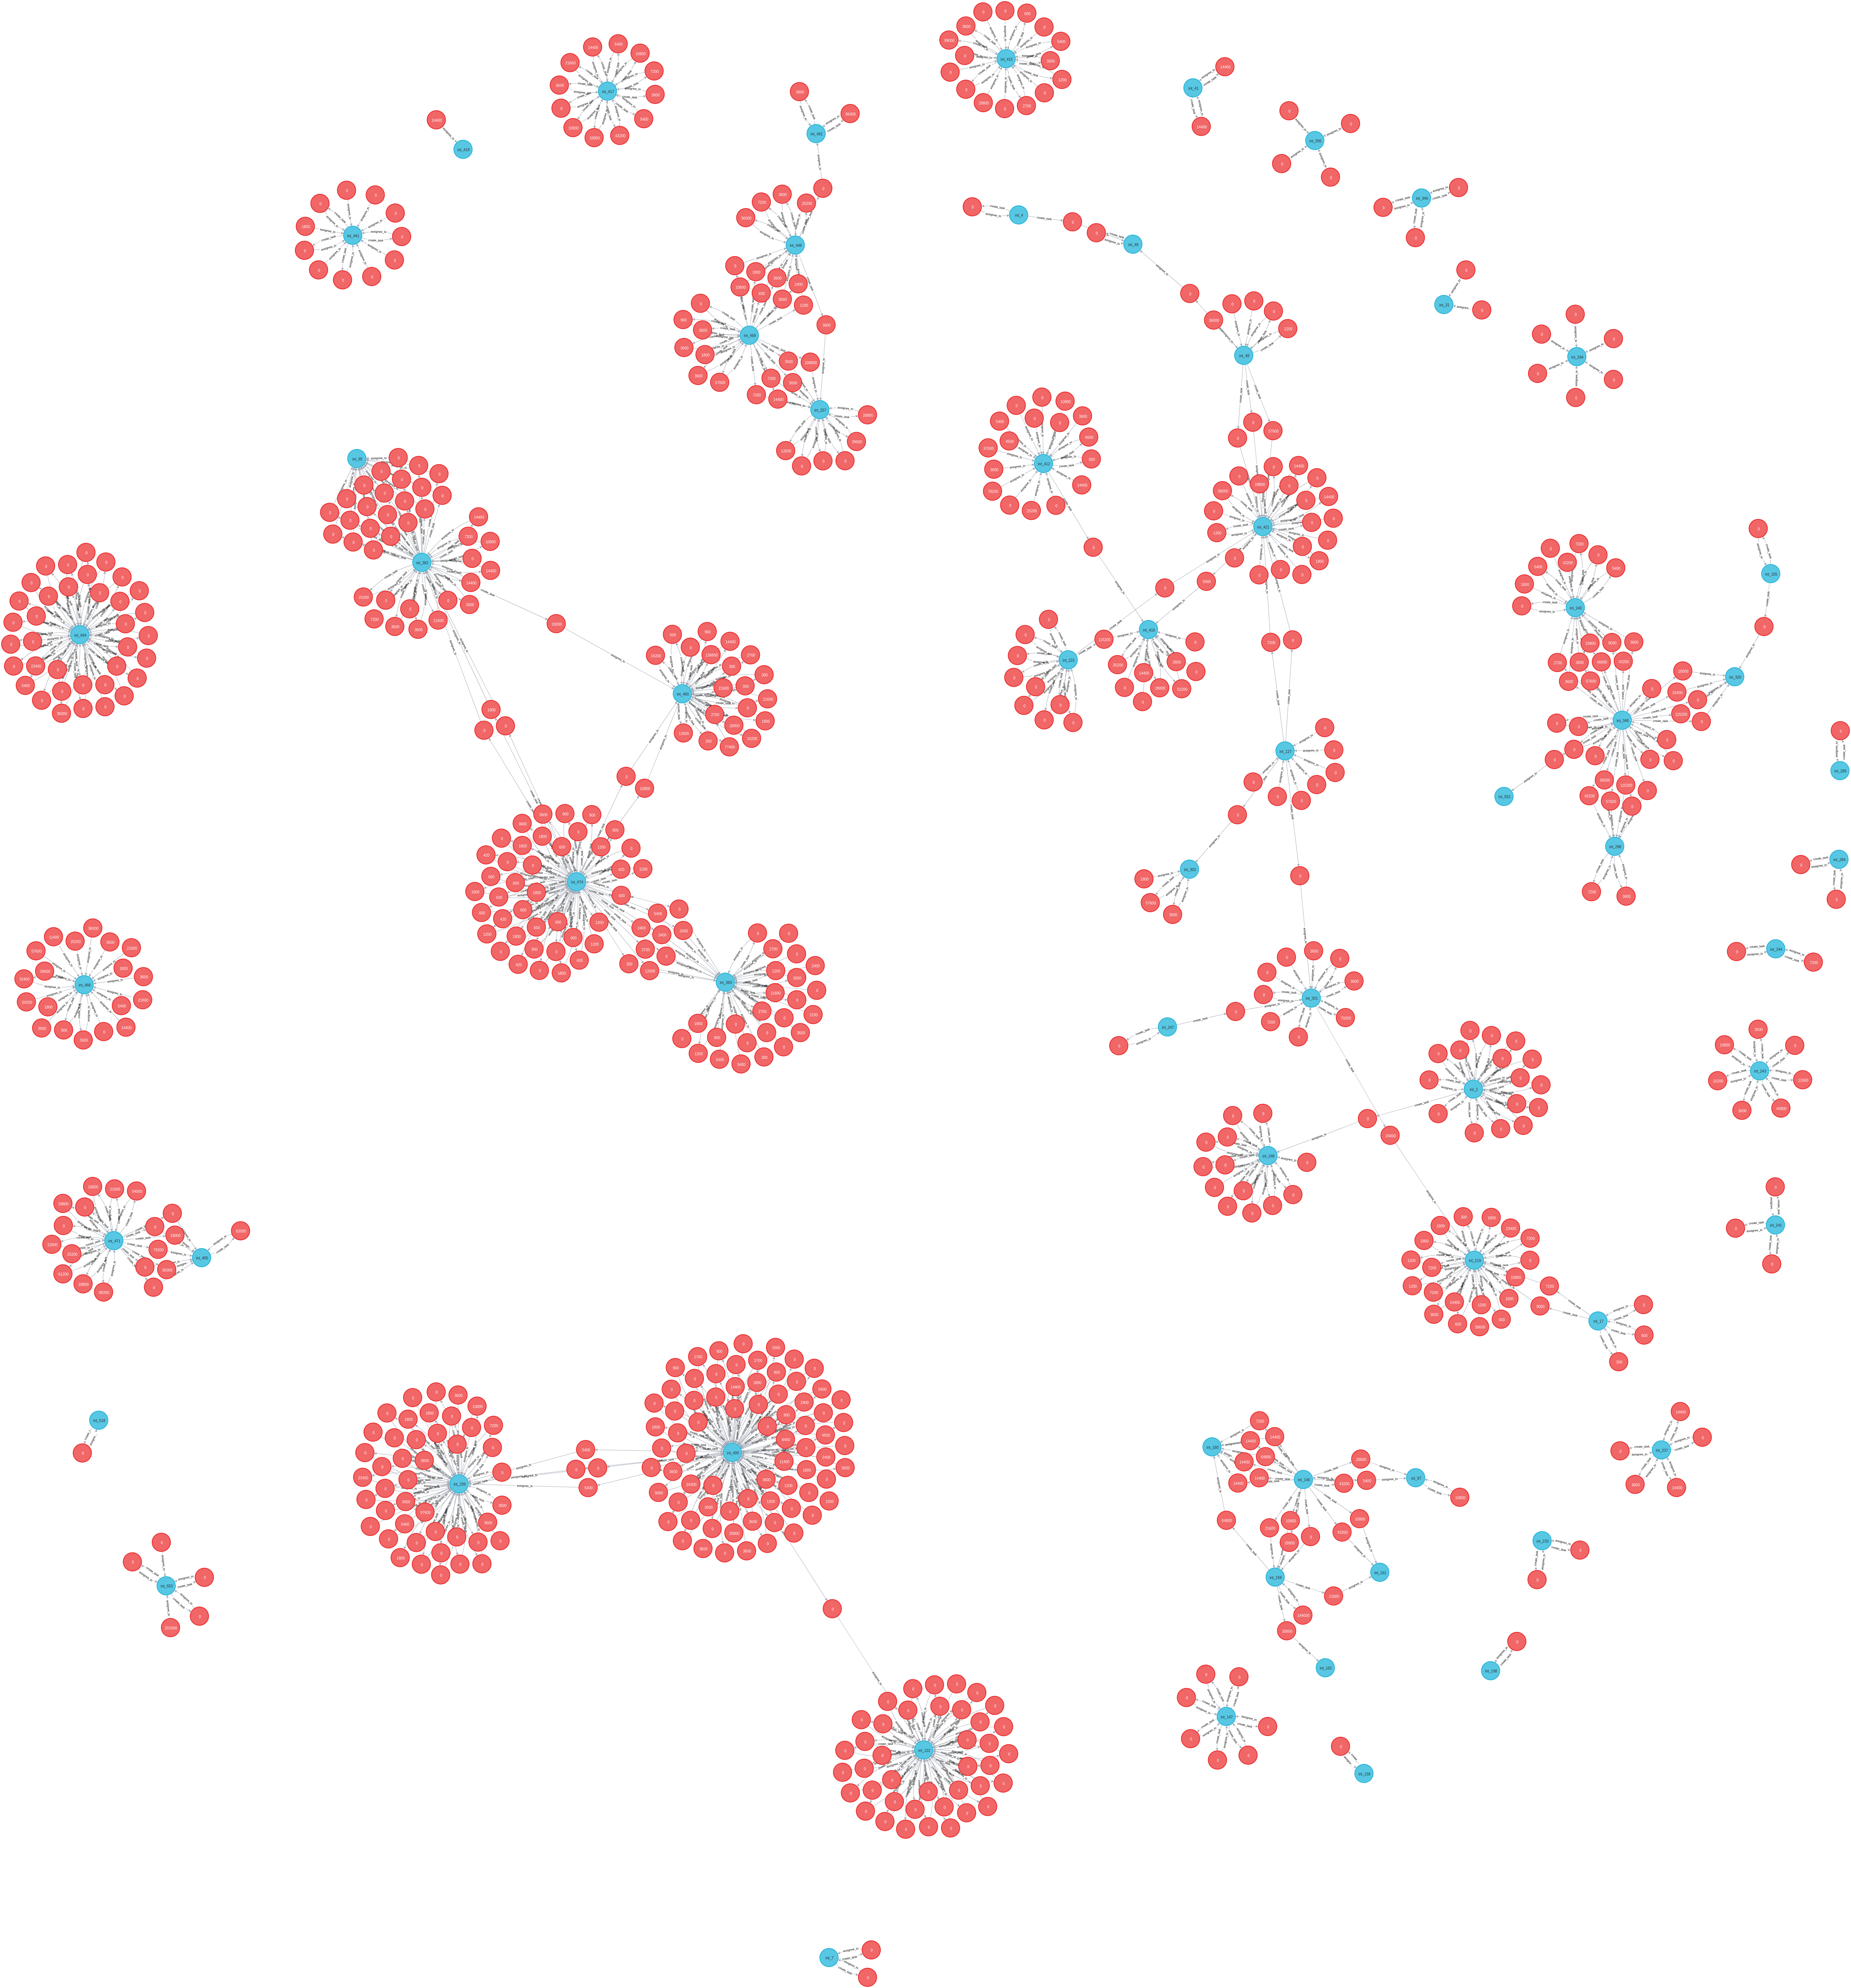

In [351]:
from IPython.display import Image
Image("graph.png")